In [96]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp

import pymadx
from xcoll_plotting import plot_functions as xcp

In [97]:
# FUNCTION TO FIND BAD APERTURES IN LINE THAT PREVENT CLOSED ORBIT SEARCH

def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers


In [98]:
# SPECIFIC CONVERSION FUNCTIONS 

def change_coordinates_to_b1(df):
    if 's' in df.columns:
        df['s'] = end_s - df['s']
    else:
        new_index = [end_s - i for i in df.index.values]
        df.index = new_index 
    return df


def reset_coord_cry_tracking(df, twiss):
    df['s'] = np.where(df['s'] <=  end_s-TCCS_loc, end_s-TCCS_loc-df['s'], 2*end_s-TCCS_loc-df['s'])
    names = twiss.to_pandas().name.to_numpy()
    idx = np.where(names == TCCS_name)[0][0]
    names = np.roll(names, -idx)
    df['name'] = names
    df = df.sort_values(by="s")
    return df


def extract_channelled(df):
    df = df.loc[(df['s']<end_s-TCCS_loc) & (df['s']>end_s-TCLA_loc)]
    return df


def filter_aperture_rotations(df, line):    
    aperture_offsets = []
    for name, element in line.element_dict.items():
        if '_tilt_entry' in name and element.__class__.__name__.startswith('SRotation'):
            aper_name = name.split('_tilt')[0]
            aperture_offsets.append(aper_name)#[aper_name] = (element.s)

    return df[~df['name'].str.contains('|'.join(aperture_offsets), case=False)]

In [99]:
# STANDARD CONVERSION FUNCTIONS

def _norm_to_geom_emittance(norm_emittance, E0, E):
    betagamma = _calc_betagamma(E0, E)
    return norm_emittance / betagamma

def _calc_betagamma(E0, E):
    gamma = float(E)/E0
    beta = np.sqrt(1.-(1./gamma)**2)
    return beta*gamma

def rad_to_deg(n):
    return n*180/np.pi

def convert_m_to_mm(val):
    return val / 1e-3

def convert_mm_to_m(val):
    return val * 1e-3



In [100]:
# LOAD COLLIMATORS FUNCTIONS

def add_collimator_halfgap(coll_df, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy):
        
    # Calculate the geometric emittances first
    emit_geom_x = _norm_to_geom_emittance(nemitt_x, reference_mass, reference_energy)
    emit_geom_y = _norm_to_geom_emittance(nemitt_y, reference_mass, reference_energy)

    openings = []
    sigmas_x = []
    sigmas_y = []
    for name, parameters in coll_df.iterrows():
        betx = parameters["betx"]
        bety = parameters["bety"]

        nsigma = parameters["gap"]
        angle  = parameters["angle"]

        sigma_x = np.sqrt(betx * emit_geom_x)
        sigma_y = np.sqrt(bety * emit_geom_y)

        a = nsigma * sigma_x
        b = nsigma * sigma_y

        x = a * np.cos(angle)
        y = b * np.sin(angle)

        sigmas_x.append(sigma_x)
        sigmas_y.append(sigma_y)
        openings.append(np.sqrt(x**2 + y**2))

    coll_df['sigma_x'] = sigmas_x
    coll_df['sigma_y'] = sigmas_y
    coll_df['opening'] = openings
    


def load_coll_yaml(filename, optics_df, reference_mass, reference_energy,
                          nemitt_x = 3.5e-6, nemitt_y = 3.5e-6, beam = 2):
    
    # load collimators form yaml file as pandas
    with open(filename, 'r') as file:
           collimators = yaml.safe_load(file)   
    coll_dict  = collimators['collimators'][f'b{beam}']
    df = pd.DataFrame.from_dict(coll_dict, orient="index")
    df = df.rename_axis('name').reset_index()
    coll_list = df['name'].to_list()
    
    # merge it with dataframe from twiss
    df_col_twiss = optics_df[optics_df['name'].isin(coll_list)]
    df_coll_tot = pd.merge(df, df_col_twiss, on="name")
    
    add_collimator_halfgap(df_coll_tot, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy)
    return df_coll_tot

In [101]:
# PLOT COLLIMATORS 

def plot_collimators(coll_data, ax, plane, df_twiss, df_chann, plot_offplane_coll = True):

    coll_data = change_coordinates_to_b1(coll_data)


    hors = (coll_data['angle'] <  rad_to_deg(0.1)) | (coll_data['angle'] >  rad_to_deg(6.1))
    vers = (coll_data['angle'] >  rad_to_deg(1.5)) & (coll_data['angle'] <  rad_to_deg(1.6))


    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]
    


    if plane == 'h':
        in_plane_collimators = collimators_hor
        off_plane_collimators = pd.concat([collimators_ver, collimators_ske])
    elif plane == 'v':
        in_plane_collimators = collimators_ver
        off_plane_collimators = pd.concat([collimators_hor, collimators_ske])
    else:
        raise Exception(f'Cannot use plane "{[plane]}", '
                        'allowed planes for aperture plot are h and v')

    coll_lw = 1

    for index, coll in in_plane_collimators.iterrows():
        s_centre = coll["s"]
        hgap    = coll["opening"]

        if(coll['name'] == TCCS_name):
            s_centre = float(df_twiss[df_twiss["name"] == TCCS_name]['s'])
            hgap = df_twiss[df_twiss['s'] == s_centre]['5_sigma_y'].iloc[0]
        elif(coll['name'] == TCCP_name):
            s_centre = float(df_twiss[df_twiss["name"] == TCCP_name]['s'])
            hgap = df_chann[df_chann['s'] == s_centre]['y'].iloc[0]
        elif(coll['name'] == TARGET_name):
            continue


        orbit = coll['x'] if plane=='h' else coll['y']
        sstart  = s_centre - coll["length"]/2
        send    = s_centre + coll["length"]/2
        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h       = top_lim - hgap
        
        
        if coll['side'] == 'left':
            color = 'r' if not pd.isna(coll['crystal']) else 'k'
            jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                        fc=color, ec=color, lw=coll_lw, zorder=10)
            ax.add_patch(jaw)

        elif coll['side'] == 'right': 
            color = 'r' if not pd.isna(coll['crystal']) else 'k'      
            jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                        fc=color, ec=color, lw=coll_lw,  zorder=10)
            ax.add_patch(jaw)
            
        else:
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw, zorder=10)
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw,  zorder=10)
            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)


    if plot_offplane_coll:
        for index, coll in off_plane_collimators.iterrows():
            s_centre = coll["s"]
            sstart  = s_centre - coll["length"]/2
            send    = s_centre + coll["length"]/2
            orbit = coll['x'] if plane=='h' else coll['y']

            alpha = 1
            color = 'slategray'
            edcgecolor = 'slategray'

            coll_angle = coll['angle']
            coll_opening = coll['opening']
            if plane == 'h':
                hgap = (coll_opening / np.abs(np.cos(coll_angle)) 
                        if not np.isclose(np.cos(coll_angle), 0) else np.inf)
            elif plane == 'v':
                hgap = (coll_opening/ np.abs(np.sin(coll_angle)) 
                        if not np.isclose(np.sin(coll_angle), 0) else np.inf)

            if np.isnan(hgap) or hgap > 0.900:
                hgap = 0 # Closed bars for non-cut collimators
                alpha = 1
                color = 'lightgray'
                edcgecolor = 'lightgray'

            w       = send-sstart
            top_lim = plt.ylim()[1]*2
            bot_lim = plt.ylim()[0]*2
            h       = top_lim - hgap
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                            fc=color, ec=edcgecolor, alpha=alpha, 
                                            lw=coll_lw, zorder=0)
            
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0,
                                            fc=color, ec=edcgecolor, alpha=alpha, 
                                            lw=coll_lw, zorder=0)

            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)

In [102]:
# PLOT 

def plot_IR3(plot_axis, df_ref, df_chann, df_chann_upper, df_chann_lower, df_apertures, df_coll=None, s_start=6300, s_stop=7100):
    
    plot_axis.plot(df_ref["s"],df_ref["y"],color="orange")


    plot_axis.plot(df_ref["s"],df_ref["5_sigma_y"], color='C1')
    plot_axis.plot(df_ref["s"],-df_ref["5_sigma_y"], color='C1')
    plot_axis.fill_between(df_ref["s"], df_ref["5_sigma_y"], -df_ref["5_sigma_y"], color='C1', alpha=0.3)


    plot_axis.plot(df_chann["s"],df_chann["y"], color='darkblue')
    plot_axis.plot(df_chann_upper["s"],df_chann_upper["y"], color='blue')
    plot_axis.plot(df_chann_lower["s"],df_chann_lower["y"], color='blue')
    plot_axis.fill_between(df_chann["s"], df_chann_upper["y"],df_chann_lower["y"], color='blue', alpha=0.3)


    plot_axis.set_xlabel('s [m]',  fontsize=17)
    plot_axis.set_xlim(s_start, s_stop)
    plot_axis.set_ylim(-0.03, 0.03)
    plot_axis.set_ylabel('y [m]',  fontsize=17)
    plot_axis.grid(linestyle=':')
    #plot_axis.set_yticks(ticks=plt.yticks()[0], labels=[f"{x*1e3:.{0}f}" for x in plt.yticks()[0]])
    
    
    plot_axis.tick_params(axis='both', which='major', labelsize=15)
    
    plot_axis.text(end_s - TCCS_loc, max(plot_axis.get_yticks())+0.0008, "TCCS", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCCP_loc, max(plot_axis.get_yticks())+0.0008, "TCCP", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCLA_loc, max(plot_axis.get_yticks())+0.0008, "TCLA", horizontalalignment='center', fontsize=17)

    # convert, xcp function handles dataframe in m
    xcp.plot_apertures(df_apertures[['xmin', 'xmax', 'ymin', 'ymax']].apply(lambda x: convert_mm_to_m(x)), plot_axis, "v")
    
    if df_coll is not None:
        plot_collimators(df_coll, plot_axis, "v", df_ref, df_chann, plot_offplane_coll = True)

# Load and Set-up

In [103]:
## Choose a context
context = xo.ContextCpu()         # For CPU

In [104]:
line = xt.Line.from_json('./input_files/flat_top_b2.json')

end_s = line.get_length()

normalized_emittance = 3.5e-6
c_const = 299792458

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'

TCCS_loc = end_s - 6773.7 #6775
TCCP_loc = end_s - 6653.3 #6655
TARGET_loc = end_s - (6653.3 + 0.07/2 +0.005/2)
TCLA_loc = line.get_s_position(TCLA_name)

line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name = TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TCCS_name + '_aper')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TCCP_name + '_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TARGET_name + '_aper')

Done loading line from dict.           


In [105]:
end_s-TCLA_loc
#6574.7208

6574.220793964007

In [106]:
bad_aper = find_bad_offset_apertures(line)
print('Bad apertures : ', bad_aper)
print('Replace bad apertures with Marker')
for name in bad_aper.keys():
    line.element_dict[name] = xt.Marker()
    print(name, line.get_s_position(name), line.element_dict[name])


Bad apertures :  {'tctph.4r8.a.b2_aper': (-0.04, 0.04, -0.04, 0.04, 0.16672558295218318, -0.0), 'vmabc.4l2.b.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, -0.18383135991897473, -0.0)}
Replace bad apertures with Marker
tctph.4r8.a.b2_aper 3461.1485832278486 Marker(_dummy=0)
vmabc.4l2.b.b2_aper 23206.82195866583 Marker(_dummy=0)


In [107]:
df_apertures = xcp.load_apertures(line)
df_apertures = change_coordinates_to_b1(df_apertures)

layout_file = "./input_files/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)

coll_file = "./input_files/flat_top.yaml"

pymadx.Tfs.Load> normal file


# Simulation

## 6.8 TeV

In [108]:
line.build_tracker(_context=context)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [109]:
beta_rel = line.particle_ref._xobject.beta0[0]
gamma = line.particle_ref._xobject.gamma0[0]
energy = line.particle_ref._xobject.p0c[0]

emittance_phy = normalized_emittance/(beta_rel*gamma)
critical_angle = np.sqrt(2*16/(energy*beta_rel))

In [110]:
twiss = line.twiss()


beta_y_cry1  = twiss['bety', TCCS_name]
alpha_y_cry1 = twiss['alfy', TCCS_name]

In [111]:
df_coll = load_coll_yaml(coll_file, twiss.to_pandas(), xp.PROTON_MASS_EV, line.particle_ref.energy0)

In [112]:
cry_part_opt = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1),
                        _context=context)

cry_part_chann = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6,
                        _context=context)


cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6+critical_angle,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6-critical_angle,
                        _context=context)

In [113]:
df_ref = change_coordinates_to_b1(twiss.to_pandas())
df_ref = filter_aperture_rotations(df_ref, line)
df_ref['5_sigma_y'] = 5*np.sqrt(emittance_phy*df_ref['bety'])

line.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss)
df_chann_part = filter_aperture_rotations(df_chann_part, line)
df_chann_part = extract_channelled(df_chann_part)

line.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part_upper = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss)
df_chann_part_upper = filter_aperture_rotations(df_chann_part_upper, line)
df_chann_part_upper = extract_channelled(df_chann_part_upper)

line.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part_lower = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss)
df_chann_part_lower = filter_aperture_rotations(df_chann_part_lower, line)
df_chann_part_lower = extract_channelled(df_chann_part_lower)

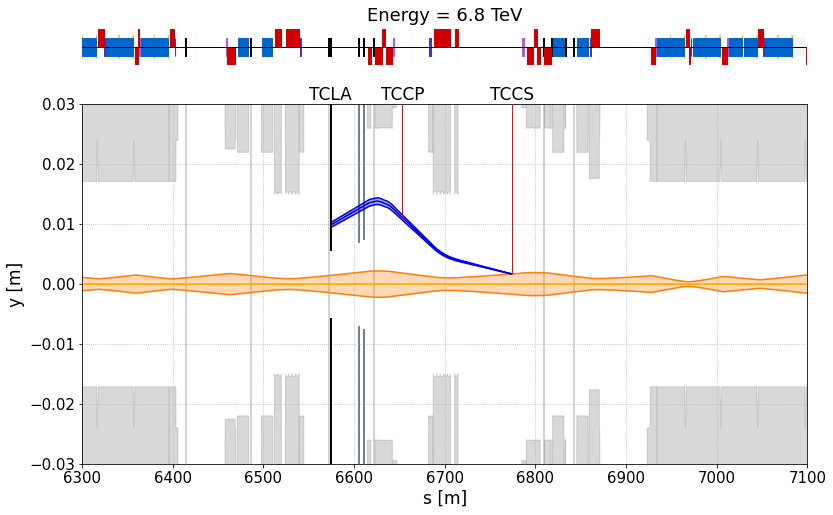

In [114]:
start, stop = 6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(13,8))
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
ir3_plot[0].set_title(label='Energy = 6.8 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot[1], df_ref, df_chann_part, df_chann_part_upper, df_chann_part_lower, df_apertures, df_coll)


In [115]:
def calc_nsigma_TCCP(df_twiss, df_chann, emittance_phy):

    s_centre = float(df_twiss[df_twiss["name"] == TCCP_name]['s'])
    hgap =  df_chann[df_chann['s'] == s_centre]['y'].iloc[0]  - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    beta_y = float(df_twiss[df_twiss["name"] == TCCP_name]['bety'])
    sigma =  np.sqrt(emittance_phy*beta_y)

    #five_sig_gap  = df_twiss[df_twiss['s'] == s_centre]['5_sigma_y'].iloc[0] - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    #print('check: ', five_sig_gap/sigma)
    
    return hgap/sigma

In [116]:
print('Sigma CRY2 at 6.8 TeV = ',  calc_nsigma_TCCP(df_ref, df_chann_part, emittance_phy))

Sigma CRY2 at 6.8 TeV =  30.047083877560752


In [117]:
start = line.element_names.index(TCCS_name)
stop = line.element_names.index(TCCP_name)

all_elements_between = {}

for i in range(start, stop):
        all_elements_between[line.element_names[i]] = {}
        all_elements_between[line.element_names[i]]['s'] = end_s - line.get_s_elements()[i]
        all_elements_between[line.element_names[i]]['element'] = line[i]


In [118]:
 sigmas = []
 dx = []
 locs = []

TCCP_s =  end_s - TCCP_loc


 for name, element in all_elements_between.items():
    if name in df_chann_part.name.to_list():
      y_chann = float(df_chann_part[df_chann_part.name == name]['y'])
      y_ref = float(df_ref[df_ref.name == name]['y'])
      hgap = y_chann - y_ref
      beta_y = float(df_ref[df_ref.name == name]['bety'])
      sigma =  np.sqrt(emittance_phy*beta_y)
      sigmas.append(hgap/sigma)
      dx.append(-1*(TCCP_s - element['s']))
      locs.append(element['s'])

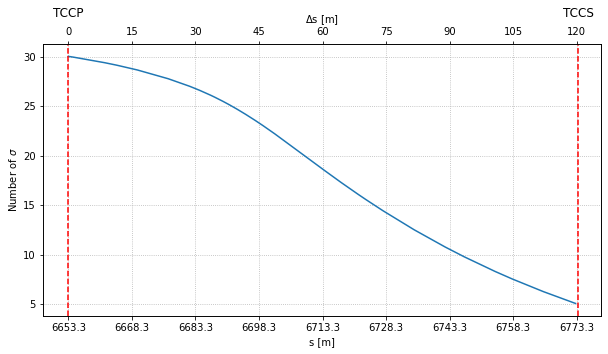

In [128]:
fig1 = plt.figure( figsize=(10, 5))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(locs, sigmas)
ax1.set_xlabel("s [m]")
ax1.set_ylabel(r'Number of $\sigma$')

n_ticks = 15
ax1.set_xticks(np.arange(np.min(locs), np.max(locs)+1, n_ticks))

ax2 = ax1.twiny()
ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels([f"{x - end_s + TCCP_loc :.{0}f}" for x in ax1.get_xticks()])
ax2.set_xlabel(r'$\Delta$s [m]')
ax1.axvline(end_s-TCCP_loc, color = 'red', linestyle = '--')#, alpha = 0.3)
ax1.axvline(end_s-TCCS_loc, color = 'red', linestyle = '--')#, alpha = 0.3)
ax1.grid(linestyle=':')
#write the name of the ip on the plot as an upper label at the top of the plot
#ax[0].text(twiss_b1[['s'],ii], max(ax[0].get_yticks()), ii, fontsize = fontsize, horizontalalignment='center')
ax1.text(end_s-TCCP_loc, max(ax1.get_yticks()) - 1,"TCCP", horizontalalignment='center', fontsize=12)
ax1.text(end_s-TCCS_loc, max(ax1.get_yticks()) - 1., "TCCS", horizontalalignment='center', fontsize=12)
plt.savefig('Outputdata/move_TCCP.png')

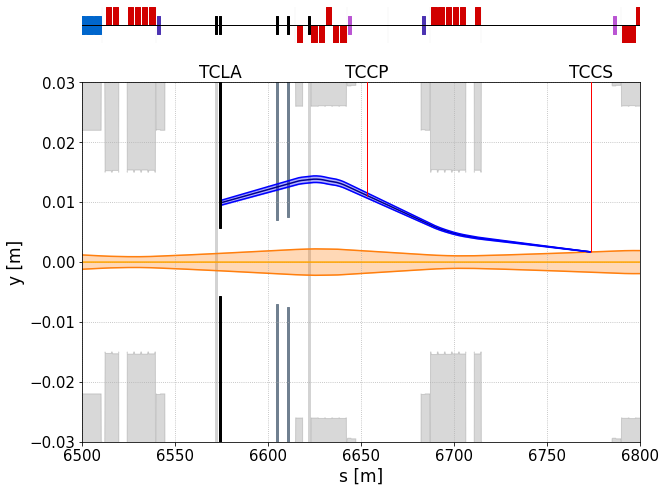

In [130]:
start, stop = 6500 , 6800
fig2, ir3_plot2 = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(10,8))
pymadx.Plot._SetMachineAxesStyle(ir3_plot2[0])
pymadx.Plot._DrawMachineLattice(ir3_plot2[0], layout_data_object)
ir3_plot2[0].set_xlim(start,stop)
#ir3_plot[0].set_title(label='Energy = 6.8 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot2[1], df_ref, df_chann_part, df_chann_part_upper, df_chann_part_lower, df_apertures, df_coll, start, stop)
plt.savefig('Outputdata/move_TCCP_IR3ZOOM.png')

# TEST S POSITIONS

In [139]:
line_b2 = xt.Line.from_json('./input_files/flat_top_b2.json')
line_b1 = xt.Line.from_json('./input_files/flat_top_b1.json')

Done loading line from dict.           
Done loading line from dict.           


In [175]:
bad_aper = find_bad_offset_apertures(line_b2)
print('Bad apertures : ', bad_aper)
print('Replace bad apertures with Marker')
for name in bad_aper.keys():
    line_b2.element_dict[name] = xt.Marker()
    print(name, line_b2.get_s_position(name), line_b2.element_dict[name])

tw_b1 = line_b1.twiss()
tw_b2 = line_b2.twiss()

Bad apertures :  {'tctph.4r8.a.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, 0.16672558295218318, -0.0), 'vmabc.4l2.b.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, -0.18383135991897473, -0.0)}
Replace bad apertures with Marker
tctph.4r8.a.b2_aper 3461.1485832278486 Marker(_dummy=0)
vmabc.4l2.b.b2_aper 23206.82195866583 Marker(_dummy=0)


In [176]:
b1 = tw_b1[:, 'ip.*'].to_pandas()
b2 = tw_b2[:, 'ip.*'].to_pandas()

In [177]:
b1 = tw_b1[:, 'tcla.*'].to_pandas()
b2 = tw_b2[:, 'tcla.*'].to_pandas()

In [183]:
b2 = tw_b2[:, 'MQWA.D4L3.B2'].to_pandas()

In [178]:
b1 = b1.drop(np.where(b1.name.str.endswith(('_aper', '.l1', '_mken', '_entry', '_exit', '_mkex')))[0])
b2 = b2.drop(np.where(b2.name.str.endswith(('_aper', '.l1', '_mken', '_entry', '_exit', '_mkex')))[0])

In [179]:
b1 = b1.sort_values(by="name")
b1[['name',"s"]]

,name,s
27,tcla.6r3.a.b1,6843.031295
43,tcla.6r3.b.b1,6844.509294
35,tcla.6r3.b1,6843.770294
45,tcla.7r3.a.b1,6914.436794
53,tcla.7r3.b.b1,6915.914794
49,tcla.7r3.b1,6915.175794
3,tcla.a5r3.a.b1,6754.480796
13,tcla.a5r3.b.b1,6755.960796
7,tcla.a5r3.b1,6755.220796
57,tcla.a6r7.a.b1,20147.349380


In [184]:
b2['s_b1'] = end_s - b2['s']
b2 = b2.sort_values(by="name")
#b2['compare'] =  b1["s"].to_list()

In [185]:
#b2[['name',"s", 's_b1', 'compare']]
b2[['name',"s", 's_b1']]

,name,s,s_b1
0,mqwa.d4l3.b2,20033.997378,6624.885794


In [ ]:
#mqwa.d4l3.b2	20033.997378	6624.885794
#                               6626.4398              3.108

In [186]:
6626.4398 - 6624.885794

1.5540060000002995

In [187]:
3.108 /2

1.554

In [130]:
 #  "TCLA.A5L3.B2"      "COLLIMATOR"                 6574.7208                  1
 #  tcla.a5l3.b2	            20084.662378	6574.220794

In [182]:
 6574.7208    -  6574.220794

0.5000060000002122

In [129]:
 b1["s"].to_list()

[0.0,
 3332.436582440849,
 6664.720796131999,
 9997.005007209149,
 13329.2892158923,
 16661.72579856215,
 19994.162380061003,
 23315.378960568854]

In [131]:
b2['compare']

1         0.000000
17     3332.436582
15     6664.720796
13     9997.005007
11    13329.289216
9     16661.725799
7     19994.162380
5     23315.378961
Name: compare, dtype: float64

In [206]:
tw_b1 = line_b1.twiss(group_compound_elements = True)
tw_b2 = line_b2.twiss(group_compound_elements = True)

In [224]:

b1_total = tw_b1.to_pandas()
b2_total = tw_b2.to_pandas()

b1_total = b1_total.drop(np.concatenate((np.where(b1_total.name.str.endswith(('_aper', '.l1', '_mken', '_entry', '_exit', '_mkex')))[0], np.where(b1_total.name.str.startswith(('v', 'drift')))[0])))
b2_total = b2_total.drop(np.concatenate((np.where(b2_total.name.str.endswith(('_aper', '.l1', '_mken', '_entry', '_exit', '_mkex')))[0], np.where(b2_total.name.str.startswith(('v', 'drift' , 'bpm')))[0])))


In [225]:
b2_total['s_b1'] = end_s - b2_total['s']
b2_total = b2_total.sort_values(by="s_b1")

In [230]:
b2_total[['name','s', 's_b1']][:10]

,name,s,s_b1
105797,_end_point,26658.883172,0.000000
105796,lhcb2ip1_p_,26658.883172,0.000000
105793,mbas2.1r1,26657.383172,1.500000
105753,tas.1r1,26638.933172,19.950000
105642,mqxa.1r1..128,26635.893482,22.989690
105639,mqxa.1r1..127,26635.843713,23.039459
105636,mqxa.1r1..126,26635.793945,23.089227
105633,mqxa.1r1..125,26635.744176,23.138996
105630,mqxa.1r1..124,26635.694407,23.188765
105627,mqxa.1r1..123,26635.644639,23.238533


In [246]:
name = 'MQXA.1L1'.lower()
a = b2_total[b2_total.name == name]
a[['name', 's', 's_b1']]

,name,s,s_b1
350,mqxa.1l1,26.15,26632.733172


In [259]:
line_b2.get_s_position()[line.element_names.index(name)]

26.150000000001455

In [ ]:
 "TAS.1R1"           "COLLIMATOR"                     20.85                1.8  

In [243]:
1.8/2

0.9

In [244]:
 20.85  - 19.95

0.9000000000000021

In [245]:
end_s

26658.883172057984

In [ ]:
26.15

In [252]:
line.element_names

('ip1_aper',
 'ip1',
 'lhcb2$end',
 'lhcb2$start',
 'ip1.l1_aper',
 'ip1.l1',
 'drift_0',
 'mbas2.1l1_aper',
 'mbas2.1l1',
 'drift_1',
 'vc1jx.1l1.d.b2_aper',
 'vc1jx.1l1.d.b2',
 'drift_2',
 'vc1jx.1l1.c.b2_aper',
 'vc1jx.1l1.c.b2',
 'drift_3',
 'vc1jx.1l1.b.b2_aper',
 'vc1jx.1l1.b.b2',
 'drift_4',
 'vc1jx.1l1.a.b2_aper',
 'vc1jx.1l1.a.b2',
 'vc1jp.1l1.g.b2_aper',
 'vc1jp.1l1.g.b2',
 'drift_5',
 'vc1jp.1l1.f.b2_aper',
 'vc1jp.1l1.f.b2',
 'drift_6',
 'vc1jp.1l1.e.b2_aper',
 'vc1jp.1l1.e.b2',
 'drift_7',
 'vc1jp.1l1.d.b2_aper',
 'vc1jp.1l1.d.b2',
 'drift_8',
 'vc1jp.1l1.c.b2_aper',
 'vc1jp.1l1.c.b2',
 'drift_9',
 'vc1jp.1l1.b.b2_aper',
 'vc1jp.1l1.b.b2',
 'drift_10',
 'vc1jp.1l1.a.b2_aper',
 'vc1jp.1l1.a.b2',
 'vc1s.a1l1.d.b2_aper',
 'vc1s.a1l1.d.b2',
 'drift_11',
 'tas.1l1_mken_aper',
 'tas.1l1_mken',
 'drift_12',
 'tas.1l1_aper',
 'tas.1l1',
 'drift_13',
 'tas.1l1_mkex_aper',
 'tas.1l1_mkex',
 'drift_14',
 'vc1s.a1l1.c.b2_aper',
 'vc1s.a1l1.c.b2',
 'drift_15',
 'vc1s.a1l1.b.b2_aper',
 

In [250]:
name

'mqxa.1l1'

In [257]:
line.element_names.index(name)

350

In [254]:
np.where(line.element_names == 'drift_320')

(array([], dtype=int64),)

26.150000000001455

In [262]:
line_b1[0].__name__

AttributeError: 'LimitEllipse' object has no attribute '__name__'

In [265]:
end_s -TCLA_loc


6574.220793964007

In [267]:
6574.7208 - end_s  + TCLA_loc

0.5000060359925556